In [0]:
#!nvcc --version

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [33]:
!nvidia-smi

Thu Oct 24 06:34:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |    160MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#pip install tensorflow-gpu

In [7]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Training dataset: (60000, 28, 28)
Testing dataset: (10000, 28, 28)
label: 5


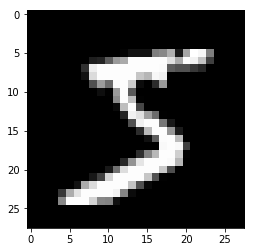

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

print("Training dataset: {}".format(x_train.shape))
print("Testing dataset: {}".format(x_test.shape))
print("label: {}".format(y_train[0]))
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [0]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_train, y_train, batch_size=32, epochs=5)

model.evaluate(x_test, y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2910 - accuracy: 0.9163
Epoch 2/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1424 - accuracy: 0.9577
Epoch 3/5
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1073 - accuracy: 0.9679
Epoch 4/5
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0878 - accuracy: 0.9728
Epoch 5/5
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0744 - accuracy: 0.9769
10000/1 - 1s - loss: 0.0433 - accuracy: 0.9762


[0.07775203005913645, 0.9762]

In [0]:
# Destroys the current TF graph and creates a new one.
tf.keras.backend.clear_session()

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [0]:
from tensorflow.keras import Model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = Flatten()
        self.dropout = Dropout(0.2)
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

model = MyModel()

In [20]:
model.build(input_shape=(None, 28, 28))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [25]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {:0}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, Test Accuracy: {:.2f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           test_loss.result(),
                           test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.25, Accuracy: 92.95, Test Loss: 0.13, Test Accuracy: 95.92
Epoch 2, Loss: 0.11, Accuracy: 96.75, Test Loss: 0.10, Test Accuracy: 96.88
Epoch 3, Loss: 0.08, Accuracy: 97.74, Test Loss: 0.09, Test Accuracy: 97.36
Epoch 4, Loss: 0.06, Accuracy: 98.27, Test Loss: 0.08, Test Accuracy: 97.58
Epoch 5, Loss: 0.04, Accuracy: 98.68, Test Loss: 0.08, Test Accuracy: 97.61


In [26]:
# TensorFlow 1.x style
# Graph and Session
with tf.Graph().as_default():
    a = tf.constant(20.0)
    print(a)
    with tf.compat.v1.Session() as sess:
        print(sess.run(a))

Tensor("Const:0", shape=(), dtype=float32)
20.0


In [27]:
# TensorFlow 2 with Eager Execution by default
# no need to set up Graph and Session
a = tf.constant(20.0)
print(a)
print(a.numpy())

tf.Tensor(20.0, shape=(), dtype=float32)
20.0


In [0]:
def f(x, y):
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

@tf.function
def g(x, y):
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

In [0]:
x = tf.constant([[2.0, 3.0]])
y = tf.constant([[3.0, -2.0]])

In [0]:
# `f` and `g` will return the same value, but `g` will be executed as a
# TensorFlow graph.
assert f(x, y).numpy() == g(x, y).numpy()

In [34]:
%time for i in range(10000): f(x, y)
%time for i in range(10000): g(x, y)

CPU times: user 9.95 s, sys: 1.2 s, total: 11.1 s
Wall time: 7.84 s
CPU times: user 8.87 s, sys: 870 ms, total: 9.74 s
Wall time: 6.32 s


In [37]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))
  
x = tf.constant(100.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
dy_dx = g.gradient(y, x) # Will be evaluated as NaN.
dy_dx.numpy()  

nan

In [38]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad
  
x = tf.constant(100.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
dy_dx = g.gradient(y, x) # Will be 1.0 when evaluated.
dy_dx.numpy()  

1.0